# Image Classification Project 6
Choose three classes from the Open Images Dataset. Train a neural net that is able to classify images into these three categories.



In [21]:
classes = ['Cat', 'Dog', 'Person']
print(classes)

['Cat', 'Dog', 'Person']


## Dataset
https://storage.googleapis.com/openimages/web/visualizer/index.html?type=detection

## Base model
VGG 19

In [22]:
# imports
import os
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from openimages import download
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import tensorflow as tf

# check gpus
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# print name of gpu
tf.config.experimental.list_physical_devices('GPU')


Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Path to the directory where the images are stored
base_dir = './dataset'

# Create the base directory if it doesn't exist
os.makedirs(base_dir, exist_ok=True)

# Check if the directory exists
if os.path.exists(base_dir):
    # Delete the directory and its contents
    shutil.rmtree(base_dir)

train_size = 1000
test_size = 300

# Download images for each class using Open Images
download.download_dataset(dest_dir=base_dir+"/train", class_labels=classes, limit=train_size)

# Download images for each class using Open Images
download.download_dataset(dest_dir=base_dir+"/test", class_labels=classes, limit=test_size)

2023-06-10  20:36:08 INFO Downloading 1000 train images for class 'cat'
100%|██████████| 1000/1000 [00:39<00:00, 25.15it/s]
2023-06-10  20:36:48 INFO Downloading 1000 train images for class 'dog'
100%|██████████| 1000/1000 [00:41<00:00, 24.14it/s]
2023-06-10  20:37:30 INFO Downloading 1000 train images for class 'person'
100%|██████████| 1000/1000 [00:40<00:00, 24.70it/s]
2023-06-10  20:40:06 INFO Downloading 300 train images for class 'cat'
100%|██████████| 300/300 [00:11<00:00, 25.86it/s]
2023-06-10  20:40:17 INFO Downloading 300 train images for class 'dog'
100%|██████████| 300/300 [00:13<00:00, 22.68it/s]
2023-06-10  20:40:31 INFO Downloading 300 train images for class 'person'
100%|██████████| 300/300 [00:13<00:00, 21.78it/s]


{'cat': {'images_dir': './dataset/test\\cat\\images'},
 'dog': {'images_dir': './dataset/test\\dog\\images'},
 'person': {'images_dir': './dataset/test\\person\\images'}}

## Task
1. Preparation: Split dataset into a 70/30 Train/test split


In [23]:
# change classes to lower case
classes = [x.lower() for x in classes]


IMAGE_SIZE = [224, 224] #Default image size for VGG19

datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)
#Through flow_from_directory - we create an array of images that can be used for training.
training_set = datagen.flow_from_directory(base_dir+"/train", target_size = (224, 224), batch_size = 32, class_mode = 'categorical')
#Through flow_from_directory - we create an array of images that can be used for test.
test_set = datagen.flow_from_directory(base_dir+"/test", target_size = (224, 224), batch_size = 32, class_mode = 'categorical')

Found 3000 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


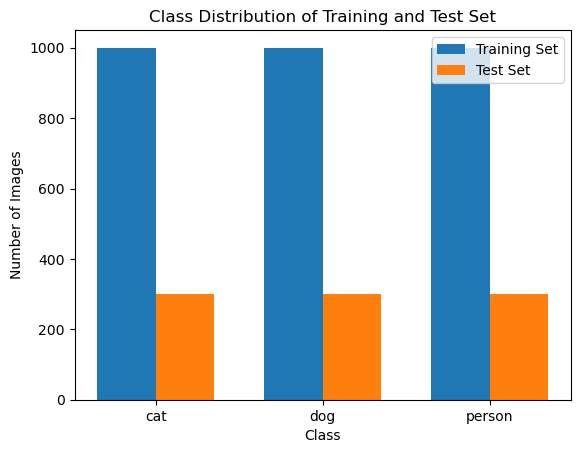

In [24]:
# Get the class labels and their indices
class_labels = training_set.class_indices

# Get the number of images in the training set
num_training_images = training_set.classes.shape[0]

# Get the number of images in the test set
num_test_images = test_set.classes.shape[0]

# Calculate the class counts for the training set
training_class_counts = [0] * len(class_labels)
for i in range(num_training_images):
    class_index = training_set.classes[i]
    training_class_counts[class_index] += 1

# Calculate the class counts for the test set
test_class_counts = [0] * len(class_labels)
for i in range(num_test_images):
    class_index = test_set.classes[i]
    test_class_counts[class_index] += 1

# Get the class labels as a list
labels = list(class_labels.keys())

# Plotting the class distribution
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_class_counts, width, label='Training Set')
rects2 = ax.bar(x + width/2, test_class_counts, width, label='Test Set')

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution of Training and Test Set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

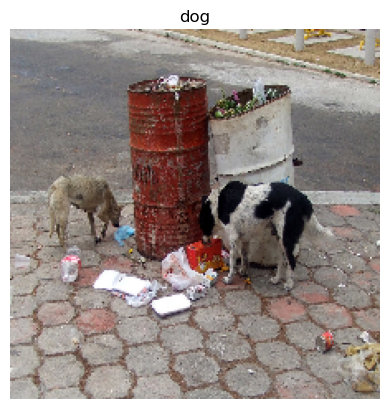

In [25]:
# Get the first batch of images and labels from the training set
images, labels = next(training_set)

# Retrieve the first image and its label
image = images[1]
label = labels[1]

# Get the class labels
class_labels = list(training_set.class_indices.keys())

# Get the corresponding label text
label_text = class_labels[np.argmax(label)]

# Display the first image with the label as the title
plt.imshow(image)
plt.axis('off')
plt.title(label_text)
plt.show()

2. Train a VGG19 network from scratch (randomly initialized weights) and estimate the testset accuracy.

### VGG19 with no weights and normal training data

In [9]:
# Use this line for VGG19 network
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights=None, include_top=False)

# This sets the base that the layers are not trainable.
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(classes), activation='softmax')(x) # We have 3 classes

#Creating model object
vgg19_no_weights_normal = Model(inputs=vgg.input, outputs=prediction)
vgg19_no_weights_normal.summary()
#Compile the model
vgg19_no_weights_normal.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_no_weights_normal_history = vgg19_no_weights_normal.fit(training_set,validation_data=test_set, epochs=10, batch_size=32)
# Save the model
vgg19_no_weights_normal.save("models/vgg19_no_weights_normal.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

KeyboardInterrupt: 

3. Use an imagenet pretrained VGG19 network, train the model and estimate the testset accuracy.

### VGG19 with imagenet weights and normal training data

In [ ]:
# Use this line for VGG19 network
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# This sets the base that the layers are not trainable.
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(classes), activation='softmax')(x) # We have 3 classes

#Creating model object
vgg19_imagenet_normal = Model(inputs=vgg.input, outputs=prediction)
vgg19_imagenet_normal.summary()

#Compile the model
vgg19_imagenet_normal.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_imagenet_normal_history = vgg19_imagenet_normal.fit(training_set,validation_data=test_set, epochs=10, batch_size=32)

vgg19_imagenet_normal.save("models/vgg19_imagenet_normal.h5")

#### The differences in loss and accuracy of the plain and pre trained network over the first 10 epochs

In [ ]:
# Extract loss and accuracy values for both models
vgg19_no_weights_normal_loss = vgg19_no_weights_normal_history.history['loss']
vgg19_no_weights_normal_accuracy = vgg19_no_weights_normal_history.history['accuracy']
vgg19_imagenet_normal_loss = vgg19_imagenet_normal_history.history['loss']
vgg19_imagenet_normal_accuracy = vgg19_imagenet_normal_history.history['accuracy']

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), vgg19_no_weights_normal_loss, 'b-', label='vgg19_no_weights_normal')
plt.plot(range(1, 11), vgg19_imagenet_normal_loss, 'r-', label='vgg19_imagenet_normal')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), vgg19_no_weights_normal_accuracy, 'b-', label='vgg19_no_weights_normal')
plt.plot(range(1, 11), vgg19_imagenet_normal_accuracy, 'r-', label='vgg19_imagenet_normal')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4. Data cleansing: Remove “bad” images from the dataset. Which did you remove? How many? Discuss results.

In [ ]:
import cv2
import os
from PIL import Image
from skimage.metrics import structural_similarity as ssim

def is_image_blurry(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur_score = cv2.Laplacian(gray, cv2.CV_64F).var()
    return blur_score < 50

def remove_bad_images(dataset_dir):
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            image_path = os.path.join(root, file)
            is_blurry = is_image_blurry(image_path)

            if is_blurry:
                # os.remove(image_path)
                print("Remove Image:" + image_path)


remove_bad_images('./dataset/train')
remove_bad_images('./dataset/test')

In [ ]:
# Get the class labels and their indices
class_labels = training_set.class_indices

# Get the number of images in the training set
num_training_images = training_set.classes.shape[0]

# Get the number of images in the test set
num_test_images = test_set.classes.shape[0]

# Calculate the class counts for the training set
training_class_counts = [0] * len(class_labels)
for i in range(num_training_images):
    class_index = training_set.classes[i]
    training_class_counts[class_index] += 1

# Calculate the class counts for the test set
test_class_counts = [0] * len(class_labels)
for i in range(num_test_images):
    class_index = test_set.classes[i]
    test_class_counts[class_index] += 1

# Get the class labels as a list
labels = list(class_labels.keys())

# Plotting the class distribution
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_class_counts, width, label='Training Set')
rects2 = ax.bar(x + width/2, test_class_counts, width, label='Test Set')

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution of Training and Test Set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

5. Add data augmentation: 
    - Random flip
    - Random contrast
    - Random translation

In [26]:
import random
def add_noise(img):
    # Add random noise to an image
    variability = 50
    deviation = variability*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.clip(img, 0., 255.)
    return img

In [27]:
augmented_datagen = ImageDataGenerator(rescale = 1./255,
    validation_split=0.3,
    horizontal_flip=True,  # Apply random flip
    vertical_flip=True,  # Apply random flip
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    preprocessing_function=add_noise,
)

#Through flow_from_directory - we create an array of images that can be used for training.
augmented_training_set = augmented_datagen.flow_from_directory(base_dir+"/train", target_size = (224, 224), batch_size = 32, class_mode = 'categorical')


# test_set = datagen.flow_from_directory(base_dir+"/test", target_size = (224, 224), batch_size = 32, class_mode = 'categorical')

Found 3000 images belonging to 3 classes.


#### Train both models again

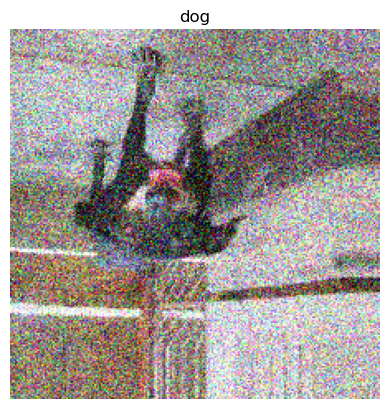

In [28]:
# Get the first batch of images and labels from the training set
images, labels = next(augmented_training_set)

# Retrieve the first image and its label
image = images[1]
label = labels[1]

# Get the class labels
class_labels = list(augmented_training_set.class_indices.keys())

# Get the corresponding label text
label_text = class_labels[np.argmax(label)]

# Display the first image with the label as the title
plt.imshow(image)
plt.axis('off')
plt.title(label_text)
plt.show()

### VGG19 with imagenet weights and augmented training data

In [ ]:
# Use this line for VGG19 network
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights=None, include_top=False)

# This sets the base that the layers are not trainable.
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(classes), activation='softmax')(x) # We have 3 classes

#Creating model object
vgg19_no_weights_augmented = Model(inputs=vgg.input, outputs=prediction)
vgg19_no_weights_augmented.summary()
#Compile the model
vgg19_no_weights_augmented.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_no_weights_augmented_history = vgg19_no_weights_augmented.fit(augmented_training_set,validation_data=test_set, epochs=10, batch_size=32)
# Save the model
vgg19_no_weights_augmented.save("models/vgg19_no_weights_augmented.h5")

### VGG19 with imagenet weights and augmented training data

In [ ]:
# Use this line for VGG19 network
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# This sets the base that the layers are not trainable.
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(classes), activation='softmax')(x) # We have 3 classes

#Creating model object
vgg19_imagenet_augmented = Model(inputs=vgg.input, outputs=prediction)
vgg19_imagenet_augmented.summary()

#Compile the model
vgg19_imagenet_augmented.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_imagenet_augmented_history = vgg19_imagenet_augmented.fit(augmented_training_set,validation_data=test_set, epochs=10, batch_size=32)

vgg19_imagenet_augmented.save("models/vgg19_imagenet_augmented.h5")

In [ ]:
# Extract loss and accuracy values for both models
vgg19_no_weights_augmented_loss = vgg19_no_weights_augmented_history.history['loss']
vgg19_no_weights_augmented_accuracy = vgg19_no_weights_augmented_history.history['accuracy']
vgg19_imagenet_augmented_loss = vgg19_imagenet_augmented_history.history['loss']
vgg19_imagenet_augmented_accuracy = vgg19_imagenet_augmented_history.history['accuracy']

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), vgg19_no_weights_augmented_loss, 'b-', label='vgg19_no_weights_augmented')
plt.plot(range(1, 11), vgg19_imagenet_augmented_loss, 'r-', label='vgg19_imagenet_augmented')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), vgg19_no_weights_augmented_accuracy, 'b-', label='vgg19_no_weights_augmented')
plt.plot(range(1, 11), vgg19_imagenet_augmented_accuracy, 'r-', label='vgg19_imagenet_augmented')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

6. Rebuild VGG19. After layer block4_conv4 (25, 25, 512):
    - Add inception layer with dimensionality reduction (no of output filters should be 512, choose own values for the filter dimensionality reduction in 1x1 layers)
    - Add conv layer (kernel 1x1,  filters 1024, padding valid, stride 1, activation leaky relu)
    - Add conv layer (kernel 3x3,  filters 1024, padding same, stride 1, activation relu)
    - Freeze conv2 layers and before

### VGG19 with no weights and normal training data Rebuilt

In [31]:
# Rebuild VGG19
from keras.layers import Conv2D, LeakyReLU

# Get the VGG19 model
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights=None, include_top=False)

# Find the index of the desired layer to insert the new layers after
index = None
for i, layer in enumerate(vgg.layers):
    if layer.name == 'block4_conv4':
        index = i
        break

if index is not None:
    # Split the model into two parts based on the desired index
    vgg_layers = vgg.layers[:index+1]
    remaining_layers = vgg.layers[index+1:]

    for layer in vgg_layers:
        layer.trainable = False  # Freeze each layer

    # Add inception layer with dimensionality reduction (no of output filters should be 512, choose own values for the filter dimensionality reduction in 1x1 layers)
    inception = Conv2D(512, (1, 1), activation='relu')(vgg.layers[-1].output)
    inception.trainable = False
    # Add conv layer (kernel 1x1,  filters 1024, padding valid, stride 1, activation leaky relu)
    conv = Conv2D(1024, (1, 1), padding='valid', strides=1, activation=LeakyReLU(alpha=0.1))(inception)
    conv.trainable = False
    # Add conv layer (kernel 3x3,  filters 1024, padding same, stride 1, activation relu)
    conv = Conv2D(1024, (3, 3), padding='same', strides=1, activation='relu')(conv)
    conv.trainable = False

    # Freeze conv2 layers and before
    x = inception
    for layer in remaining_layers:
        x = layer(x)

    # Create the final prediction layer
    x = Flatten()(x)
    prediction = Dense(len(classes), activation='softmax')(x)

    # Create the rebuilt model
    vgg19_no_weights_normal_rebuilt = Model(inputs=vgg.input, outputs=prediction)
    vgg19_no_weights_normal_rebuilt.summary()
else:
    print("Desired layer 'block4_conv4' not found in VGG19 model.")

#Compile the model
vgg19_no_weights_normal_rebuilt.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_no_weights_normal_rebuilt_history = vgg19_no_weights_normal_rebuilt.fit(training_set,validation_data=test_set, epochs=10, batch_size=32)

vgg19_no_weights_normal_rebuilt.save("models/vgg19_no_weights_normal_rebuilt.h5")

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

### VGG19 with no weights and augmented training data Rebuilt

In [32]:
# VGG19 no weights augmented data rebuilt
from keras.layers import Conv2D, LeakyReLU

# Get the VGG19 model
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights=None, include_top=False)

# Find the index of the desired layer to insert the new layers after
index = None
for i, layer in enumerate(vgg.layers):
    if layer.name == 'block4_conv4':
        index = i
        break

if index is not None:
    # Split the model into two parts based on the desired index
    vgg_layers = vgg.layers[:index+1]
    remaining_layers = vgg.layers[index+1:]

    for layer in vgg_layers:
        layer.trainable = False  # Freeze each layer

    # Add inception layer with dimensionality reduction (no of output filters should be 512, choose own values for the filter dimensionality reduction in 1x1 layers)
    inception = Conv2D(512, (1, 1), activation='relu')(vgg.layers[-1].output)
    inception.trainable = False
    # Add conv layer (kernel 1x1,  filters 1024, padding valid, stride 1, activation leaky relu)
    conv = Conv2D(1024, (1, 1), padding='valid', strides=1, activation=LeakyReLU(alpha=0.1))(inception)
    conv.trainable = False
    # Add conv layer (kernel 3x3,  filters 1024, padding same, stride 1, activation relu)
    conv = Conv2D(1024, (3, 3), padding='same', strides=1, activation='relu')(conv)
    conv.trainable = False

    # Freeze conv2 layers and before
    x = inception
    for layer in remaining_layers:
        x = layer(x)

    # Create the final prediction layer
    x = Flatten()(x)
    prediction = Dense(len(classes), activation='softmax')(x)

    # Create the rebuilt model
    vgg19_no_weights_augmented_rebuilt = Model(inputs=vgg.input, outputs=prediction)
    vgg19_no_weights_augmented_rebuilt.summary()
else:
    print("Desired layer 'block4_conv4' not found in VGG19 model.")

#Compile the model
vgg19_no_weights_augmented_rebuilt.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_no_weights_augmented_rebuilt_history = vgg19_no_weights_augmented_rebuilt.fit(augmented_training_set,validation_data=test_set, epochs=10, batch_size=32)

vgg19_no_weights_augmented_rebuilt.save("models/vgg19_no_weights_augmented_rebuilt.h5")

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

### VGG19 with imagenet weights and normal training data Rebuilt

In [29]:
# Rebuild VGG19
from keras.layers import Conv2D, LeakyReLU

# Get the VGG19 model
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Find the index of the desired layer to insert the new layers after
index = None
for i, layer in enumerate(vgg.layers):
    if layer.name == 'block4_conv4':
        index = i
        break

if index is not None:
    # Split the model into two parts based on the desired index
    vgg_layers = vgg.layers[:index+1]
    remaining_layers = vgg.layers[index+1:]

    for layer in vgg_layers:
        layer.trainable = False  # Freeze each layer

    # Add inception layer with dimensionality reduction (no of output filters should be 512, choose own values for the filter dimensionality reduction in 1x1 layers)
    inception = Conv2D(512, (1, 1), activation='relu')(vgg.layers[-1].output)
    inception.trainable = False
    # Add conv layer (kernel 1x1,  filters 1024, padding valid, stride 1, activation leaky relu)
    conv = Conv2D(1024, (1, 1), padding='valid', strides=1, activation=LeakyReLU(alpha=0.1))(inception)
    conv.trainable = False
    # Add conv layer (kernel 3x3,  filters 1024, padding same, stride 1, activation relu)
    conv = Conv2D(1024, (3, 3), padding='same', strides=1, activation='relu')(conv)
    conv.trainable = False

    # Freeze conv2 layers and before
    x = inception
    for layer in remaining_layers:
        x = layer(x)

    # Create the final prediction layer
    x = Flatten()(x)
    prediction = Dense(len(classes), activation='softmax')(x)

    # Create the rebuilt model
    vgg19_imagenet_normal_rebuilt = Model(inputs=vgg.input, outputs=prediction)
    vgg19_imagenet_normal_rebuilt.summary()
else:
    print("Desired layer 'block4_conv4' not found in VGG19 model.")

#Compile the model
vgg19_imagenet_normal_rebuilt.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_imagenet_normal_rebuilt_history = vgg19_imagenet_normal_rebuilt.fit(training_set, validation_data=test_set, epochs=10, batch_size=32)

vgg19_imagenet_normal_rebuilt.save("models/vgg19_imagenet_normal_rebuilt.h5")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

### VGG19 with imagenet weights and augmented training data Rebuilt

In [30]:
# Rebuild VGG19
from keras.layers import Conv2D, LeakyReLU

# Get the VGG19 model
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Find the index of the desired layer to insert the new layers after
index = None
for i, layer in enumerate(vgg.layers):
    if layer.name == 'block4_conv4':
        index = i
        break

if index is not None:
    # Split the model into two parts based on the desired index
    vgg_layers = vgg.layers[:index+1]
    remaining_layers = vgg.layers[index+1:]

    for layer in vgg_layers:
        layer.trainable = False  # Freeze each layer

    # Add inception layer with dimensionality reduction (no of output filters should be 512, choose own values for the filter dimensionality reduction in 1x1 layers)
    inception = Conv2D(512, (1, 1), activation='relu')(vgg.layers[-1].output)
    inception.trainable = False
    # Add conv layer (kernel 1x1,  filters 1024, padding valid, stride 1, activation leaky relu)
    conv = Conv2D(1024, (1, 1), padding='valid', strides=1, activation=LeakyReLU(alpha=0.1))(inception)
    conv.trainable = False
    # Add conv layer (kernel 3x3,  filters 1024, padding same, stride 1, activation relu)
    conv = Conv2D(1024, (3, 3), padding='same', strides=1, activation='relu')(conv)
    conv.trainable = False

    # Freeze conv2 layers and before
    x = inception
    for layer in remaining_layers:
        x = layer(x)

    # Create the final prediction layer
    x = Flatten()(x)
    prediction = Dense(len(classes), activation='softmax')(x)

    # Create the rebuilt model
    vgg19_imagenet_augmented_rebuilt = Model(inputs=vgg.input, outputs=prediction)
    vgg19_imagenet_augmented_rebuilt.summary()
else:
    print("Desired layer 'block4_conv4' not found in VGG19 model.")

#Compile the model
vgg19_imagenet_augmented_rebuilt.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_imagenet_augmented_rebuilt_history = vgg19_imagenet_augmented_rebuilt.fit(augmented_training_set, validation_data=test_set, epochs=10, batch_size=32)

vgg19_imagenet_augmented_rebuilt.save("models/vgg19_imagenet_augmented_rebuilt.h5")

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [ ]:
# Extract loss and accuracy values for both models
vgg19_no_weights_normal_rebuilt_loss = vgg19_no_weights_normal_rebuilt_history.history['loss']
vgg19_no_weights_normal_rebuilt_accuracy = vgg19_no_weights_normal_rebuilt_history.history['accuracy']

vgg19_no_weights_augmented_rebuilt_loss = vgg19_no_weights_augmented_rebuilt_history.history['loss']
vgg19_no_weights_augmented_rebuilt_accuracy = vgg19_no_weights_augmented_rebuilt_history.history['accuracy']

vgg19_imagenet_normal_rebuilt_loss = vgg19_imagenet_normal_rebuilt_history.history['loss']
vgg19_imagenet_normal_rebuilt_accuracy = vgg19_imagenet_normal_rebuilt_history.history['accuracy']

vgg19_imagenet_augmented_rebuilt_loss = vgg19_imagenet_augmented_rebuilt_history.history['loss']
vgg19_imagenet_augmented_rebuilt_accuracy = vgg19_imagenet_augmented_rebuilt_history.history['accuracy']

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), vgg19_no_weights_normal_rebuilt_loss, 'b-', label='vgg19_no_weights_normal_rebuilt_loss')
plt.plot(range(1, 11), vgg19_no_weights_augmented_rebuilt_loss, 'r-', label='vgg19_no_weights_augmented_rebuilt_loss')
plt.plot(range(1, 11), vgg19_imagenet_normal_rebuilt_loss, 'g-', label='vgg19_imagenet_normal_rebuilt_loss')
plt.plot(range(1, 11), vgg19_imagenet_augmented_rebuilt_loss, 'y-', label='vgg19_imagenet_augmented_rebuilt_loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), vgg19_no_weights_normal_rebuilt_accuracy, 'b-', label='vgg19_no_weights_normal_rebuilt_accuracy')
plt.plot(range(1, 11), vgg19_no_weights_augmented_rebuilt_accuracy, 'r-', label='vgg19_no_weights_augmented_rebuilt_accuracy')
plt.plot(range(1, 11), vgg19_imagenet_normal_rebuilt_accuracy, 'g-', label='vgg19_imagenet_normal_rebuilt_accuracy')
plt.plot(range(1, 11), vgg19_imagenet_augmented_rebuilt_accuracy, 'y-', label='vgg19_imagenet_augmented_rebuilt_accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

7. Test a few of your own images and present the results

In [13]:
import matplotlib.pyplot as plt
from keras.models import load_model
from keras import utils
import numpy as np

# go through the models folder and save every filename in a list
model_filenames = []
path_m = "models"
for filename in os.listdir(path_m):
    if filename.endswith(".h5"):
        model_filenames.append(filename)

models = []
for model_path in model_filenames:
    model = load_model( path_m+"\\"+ model_path)
    models.append(model)

# Preprocess your own images
path_i = "own_images"
image_filenames = []
for filename in os.listdir(path_i):
    if filename.endswith(".jpg"):
        image_filenames.append(filename)

images = []
for img_path in image_filenames:
    img = utils.load_img(path_i+"\\" + img_path, target_size=(224, 224))
    img = utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize pixel values to [0, 1]
    images.append(img)
images = np.concatenate(images, axis=0)

# Make predictions with each model on your own images
all_predictions = []
for model in models:
    predictions = model.predict(images)
    all_predictions.append(predictions)

print(all_predictions)



1/1 [==============================] - 0s 88ms/step
[array([[5.7728493e-01, 3.7587069e-02, 3.8512802e-01],
       [1.8802023e-01, 2.9411646e-02, 7.8256816e-01],
       [2.8821692e-01, 2.1262789e-02, 6.9052035e-01],
       [4.1813415e-01, 5.5291593e-01, 2.8949885e-02],
       [5.2986604e-01, 4.1993067e-01, 5.0203260e-02],
       [9.7175545e-01, 2.0804310e-02, 7.4402550e-03],
       [8.0469149e-01, 1.9265662e-01, 2.6519159e-03],
       [7.7795964e-01, 1.3202037e-01, 9.0019986e-02],
       [8.3637810e-01, 1.6309278e-01, 5.2909239e-04],
       [4.8997436e-02, 9.4959033e-01, 1.4122236e-03],
       [1.6798047e-02, 4.6200714e-01, 5.2119476e-01],
       [2.3694407e-02, 2.9608825e-01, 6.8021739e-01],
       [1.1455958e-01, 3.6267617e-01, 5.2276427e-01],
       [1.6739509e-03, 2.2960204e-01, 7.6872396e-01],
       [1.4107582e-05, 2.4583351e-03, 9.9752754e-01],
       [1.1878115e-01, 7.9340744e-01, 8.7811418e-02]], dtype=float32), array([[9.1296172e-01, 7.3633693e-02, 1.3404588e-02],
       [3.08

In [109]:
import matplotlib.pyplot as plt
from keras.models import load_model
from keras import utils
import numpy as np

# Preprocess your own images
path_i = "own_images"
image_filenames = []
for filename in os.listdir(path_i):
    if filename.endswith(".jpg"):
        image_filenames.append(filename)

print(image_filenames)

images = []
for img_path in image_filenames:
    img = utils.load_img(path_i+"\\" + img_path, target_size=(224, 224))
    img = utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize pixel values to [0, 1]
    images.append(img)
images = np.concatenate(images, axis=0)

pd.set_option('display.float_format', lambda x: '%.4f' % x)
df = pd.DataFrame(columns=['image', 'truth', 'result', 'models','cat', 'dog', 'person'])

# go through the models folder and save every filename in a list
model_filenames = []
path_m = "models"
for filename in os.listdir(path_m):
    if filename.endswith(".h5"):
        model_filenames.append(filename)

print(model_filenames)

models = []
for model_path in model_filenames:
    model = load_model( path_m+"\\"+ model_path)
    # Make predictions with each model on your own images
    predictions = model.predict(images)
    for i in range(len(image_filenames)):
        result = np.argmax(predictions[i])
        if result == 0:
            result = 'cat'
        elif result == 1:
            result = 'dog'
        else:
            result = 'person'
        df = df.append(
            {
                'models': model_path,
                'image': image_filenames[i],
                'cat': predictions[i][0],
                'dog': predictions[i][1],
                'person': predictions[i][2],
                'result': result,
                'truth': image_filenames[i].split('_')[0]
            },
            ignore_index=True
        )
# sort by image name
df = df.sort_values(by=['image'])

df.head(-1)





['cat_1.jpg', 'cat_2.jpg', 'cat_3.jpg', 'cat_x2.jpg', 'cock_.jpg', 'dog&person.jpg', 'dog_1.jpg', 'dog_2.jpg', 'dog_3.jpg', 'lemur_.jpg', 'person_1.jpg', 'person_2.jpg', 'person_3.jpg', 'person_x4.jpg', 'person_x5.jpg', 'turtle_.jpg']
['vgg19_imagenet_augmented.h5', 'vgg19_imagenet_augmented_rebuilt.h5', 'vgg19_imagenet_normal.h5', 'vgg19_imagenet_normal_rebuilt.h5', 'vgg19_no_weights_augmented.h5', 'vgg19_no_weights_augmented_rebuilt.h5', 'vgg19_no_weights_normal.h5', 'vgg19_no_weights_normal_rebuilt.h5']
1/1 [==============================] - 0s 99ms/step


,image,truth,result,models,cat,dog,person
0,cat_1.jpg,cat,cat,vgg19_imagenet_augmented.h5,0.9718,0.0208,0.0074
80,cat_1.jpg,cat,dog,vgg19_no_weights_augmented_rebuilt.h5,0.3331,0.3335,0.3334
32,cat_1.jpg,cat,cat,vgg19_imagenet_normal.h5,0.9238,0.0239,0.0523
64,cat_1.jpg,cat,cat,vgg19_no_weights_augmented.h5,0.3505,0.3339,0.3156
96,cat_1.jpg,cat,dog,vgg19_no_weights_normal.h5,0.3165,0.3518,0.3318
...,...,...,...,...,...,...,...
79,turtle_.jpg,turtle,cat,vgg19_no_weights_augmented.h5,0.3538,0.3295,0.3167
47,turtle_.jpg,turtle,dog,vgg19_imagenet_normal.h5,0.4958,0.4964,0.0078
31,turtle_.jpg,turtle,cat,vgg19_imagenet_augmented_rebuilt.h5,0.4788,0.3811,0.1402
15,turtle_.jpg,turtle,dog,vgg19_imagenet_augmented.h5,0.1188,0.7934,0.0878


In [115]:
# rank the models by counting truth == result
rank_temp = df
rank_temp['correct'] = rank_temp['truth'] == rank_temp['result']
rank_temp['correct'] = rank_temp['correct'].astype(int)
ranking = rank_temp.groupby(['models']).sum().sort_values(by=['correct'], ascending=False)
# remove cat dog person
ranking = ranking.drop(['cat', 'dog', 'person'], axis=1)
ranking.head(10)

,correct
models,
vgg19_imagenet_normal.h5,11
vgg19_imagenet_augmented.h5,10
vgg19_imagenet_normal_rebuilt.h5,10
vgg19_imagenet_augmented_rebuilt.h5,9
vgg19_no_weights_augmented.h5,5
vgg19_no_weights_normal.h5,5
vgg19_no_weights_normal_rebuilt.h5,4
vgg19_no_weights_augmented_rebuilt.h5,3


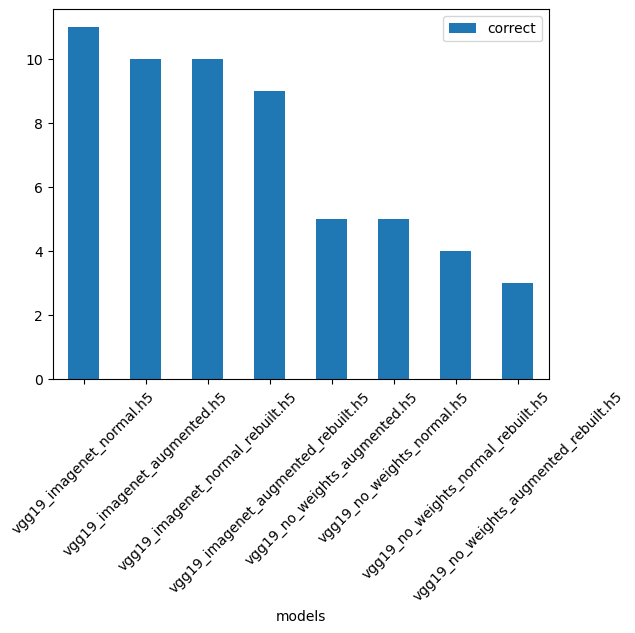

In [117]:
# plot the ranking
ranking.plot.bar()
plt.show()


8. Answer the following questions:
    - What accuracy can be achieved? What is the accuracy of the train vs. test set?
    - On what infrastructure did you train it? What is the inference time?
    - What are the number of parameters of the model?
    - Which categories are most likely to be confused by the algorithm? Show results in a confusion matrix.